[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ishandandekar/Looking-Fruit/blob/main/Looking_Fruit_nbk.ipynb)

# Looking_Fruit

👋 Hello and welcome to the **Looking_Fruit** notebook. In this notebook I try to replicate the [Fruits-360](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning) research paper. In this paper, researchers have tried to classify images of **131** fruits and vegetables. The data used for these modelling experiments is provided by the paper researchers themselves.

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-21197323-30aa-b445-fa3e-956e09871026)


## Step 0: Defining the problem


**Objective:**  
To classify the images of various fruits and vegetables with best f1-score.  

**Files:**
- *Train*: This folder contains folders labelled as fruit's/vegetable's name. These subfolders contain images of the respective fruit/vegetable. This folder will be used for training purpose.
- *Test*: This folder contains folders labelled as fruit's/vegetable's name. These subfolders contain images of the respective fruit/vegetable. This folder will be used for testing purpose.

## Step 1: Getting the data
The data used for this project is publicly available on [Kaggle](https://www.kaggle.com/datasets/ishandandekar/fruitimagedataset).

- Use Kaggle's API to download the data into Colab.
- Get utility functions to help in future.
- Configure data files to read using Python.


In [2]:
# Getting the helper functions script
!wget https://raw.githubusercontent.com/ishandandekar/Looking-Fruit/main/helper_functions.py

# Get the necessary functions from the python script
from helper_functions import plot_loss_curves, unzip_data, create_model_checkpoint, get_metrics

--2022-09-05 08:28:00--  https://raw.githubusercontent.com/ishandandekar/Looking-Fruit/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.74K  --.-KB/s    in 0s      

2022-09-05 08:28:00 (37.4 MB/s) - ‘helper_functions.py’ saved [2803/2803]



About these helper functions (see documentation for better description):
* **plot_loss_curves** : Plots a line graph (using matplotlib) to see changes in loss and accuracy during training.
* **unzip_data** : Unzips a zip file to a directory
* **create_model_checkpoint** : Create a model checkpoint with only best weights (monitored over validation loss).

In [3]:
# Install the kaggle library
!pip install -q kaggle

# Upload the Kaggle API keys
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# Copy the json file to the folder
!cp kaggle.json ~/.kaggle

# Change permissions for json to work with the Kaggle API
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d ishandandekar/fruitimagedataset

# Unzip data
unzip_data('fruitimagedataset.zip', data_dir="raw")

Saving kaggle.json to kaggle.json
 97% 385M/398M [00:03<00:00, 112MB/s]
100% 398M/398M [00:03<00:00, 130MB/s]


## Step 2: Know more about the data

- Get the statistics about the data.
- Check if the labels are imbalanced.
- Visualize random samples in data.
- (*If required*) Trim data.
- (*If required*) Preprocess the data.
- Make data processing faster using `ImageDataGenerator`.

In [5]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [6]:
# Setting up necessary variables
TRAIN_PATH = '/content/raw/train/train/'
TEST_PATH = '/content/raw/test/test/'
RAW_DATA_PATH = '/content/raw'

In [7]:
# Checking the number of classes
classes = []

for dirname, _, filenames in os.walk(RAW_DATA_PATH):
    if dirname.startswith(f"{TRAIN_PATH}"):
        classes.append(dirname[len(TRAIN_PATH):])

print(f"Total number of classes to deal with: {len(classes)}")

Total number of classes to deal with: 131


In [8]:
# Show random classes present in the dataset
list_of_five_random_labels = random.sample(classes,5)
list_of_five_random_labels

['Pomelo Sweetie', 'Pear Williams', 'Kaki', 'Kumquats', 'Lychee']

In [9]:
# Number of images of each fruit/vegetable as a pandas.DataFrame

# List to append the count of images
number_of_images_train = []

for label in classes:
    path = f'{TRAIN_PATH}/{label}'
    count = len(os.listdir(path))
    number_of_images_train.append(count)

train_image_count_df = pd.DataFrame({"Label":classes,"Number of Images":number_of_images_train})

# To view first 10 rows of the dataframe
train_image_count_df.head(10)

,Label,Number of Images
0,Pineapple Mini,493
1,Pepino,490
2,Nectarine Flat,480
3,Pear Monster,490
4,Tomato 3,738
5,Tomato 4,479
6,Apple Golden 1,480
7,Nectarine,492
8,Apple Golden 2,492
9,Apple Red Yellow 1,492


In [10]:
# Label with most number of images
print(f"Label with most number of images:")
print(train_image_count_df.sort_values("Number of Images",ascending=False).head(1))
print(f"Label with least number of images:")
print(train_image_count_df.sort_values("Number of Images",ascending=True).head(1))

Label with most number of images:
         Label  Number of Images
39  Grape Blue               984
Label with least number of images:
           Label  Number of Images
117  Ginger Root               297


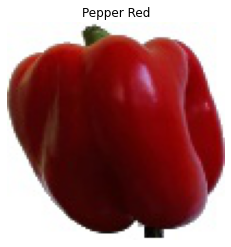

In [12]:
# Show random sample from training of a random fruit/vegetable

random_label = random.choice(classes)
sample_path = f'{TRAIN_PATH}/{random_label}'
random_image= random.choice(os.listdir(sample_path))
random_image_path = f'{sample_path}/{random_image}'

img = mpimg.imread(random_image_path)
imgplot = plt.imshow(img)
plt.axis(False)
plt.title(f'{random_label}')
plt.show()

In [13]:
# Making new directories for trimmed training data
os.mkdir("data")
os.mkdir("data/train")

In [14]:
# Trimming data as there are lot of training examples

TRAIN_IMAGES_COUNT = 100

for label in classes:
  path = f'{TRAIN_PATH}/{label}'
  img_files = os.listdir(path)
  random_count_images = random.sample(img_files, TRAIN_IMAGES_COUNT)
  new_path_for_label = f"/content/data/train/{label}"
  os.mkdir(new_path_for_label)

  for img_file in random_count_images:
    shutil.move(f"{path}/{img_file}", new_path_for_label)

In [15]:
# Image size has been specified in the research paper
IMAGE_SIZE = (100,100)
BATCH_SIZE = 32
TRIMMED_TRAIN_PATH = '/content/data/train'
TEST_PATH = '/content/raw/test/test'

# To make data processing faster
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=TRIMMED_TRAIN_PATH,
                                                               image_size=IMAGE_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=TEST_PATH,
                                                               image_size=IMAGE_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 13100 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.


In [16]:
# See an example of a batch of data
for images,labels in train_data.take(1):
  print(images,labels)

tf.Tensor(
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 2

## Step 3: Describing modelling experiments

- This notebook contains 7 models built to get the best **f1-score** on the test dataset. These models also include the models made by the researchers themselves.  
- Models to be made:
  1. **Model 0** : A simple model with fully connected multiple Dense layers; this model acts as a baseline.
  1. **Model 1** : Multiple pairs of CNN and MaxPool layers with a  Dense layer in the end for classification.
  1. **Model 2** : Replicate the best model (on the test set) from research paper; *should get better results from this.*
  1. **Model 3** : Using transfer learning, exploit ResNet model for classification.
  1. **Model 4** : Using transfer learning, exploit EfficientNetBx for classification.
  1. **Model 5** : Use fine-tuned ResNet model for classification.
  1. **Model 6** : Use fine-tuned EfficientNetBx for classification.
- Get classification metrics for each model.


In [ ]:
# Directory to save images of models' architectures
!mkdir model_architectures

#### Model 0 
* **Layers:** 3 Dense layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 10
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model
model_0 = tf.keras.Sequential([
    layers.Flatten(input_shape=(100,100,3)),
    layers.Input(shape=INPUT_SHAPE),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(131, activation="softmax")
], name="model_0_dense")

# 2. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Get the summary
model_0.summary()

# 4. Fit the model
history_model_0 = model_0.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_0.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_0, to_file='/content/model_architectures/model_0.png')

# About the model history
plot_loss_curves(history_model_0)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_0_dense"
model_0.load_weights(best_weights_path)

# Evaluate on test set
model_0.evaluate(test_data)

In [ ]:
# Unravel dataset
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
# Getting predictions on test data
model_0_preds_prob = model_0.predict(test_data, verbose=1)
model_0_preds_classes = model_0_preds_prob.argmax(axis=1)

# Getting a metrics report
model_0_metrics = get_metrics(y_labels, model_0_preds_classes)
model_0_metrics

#### Model 1 
* **Layers:** Multiple Conv2D layers paired with MaxPool layers with a Dense layer at the end
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 10
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model
model_1 = tf.keras.Sequential([
     tf.keras.layers.Conv2D(filters=10,
                            kernel_size=3,
                            activation="relu",
                            input_shape=INPUT_SHAPE),
     tf.keras.layers.Conv2D(10,3,activation="relu"),
     tf.keras.layers.MaxPool2D(pool_size=2,
                               padding="valid"),
     tf.keras.layers.Conv2D(10,3,activation="relu"),
     tf.keras.layers.Conv2D(10,3,activation="relu"),
     tf.keras.layers.MaxPool2D(2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(131,activation="softmax")
], name="model_1_Conv2D")

# 2. Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Get the summary
model_1.summary()

# 4. Fit the model
history_model_1 = model_1.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_1, to_file='/content/model_architectures/model_1.png')

# About the model history
plot_loss_curves(history_model_1)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_1_Conv2D"
model_1.load_weights(best_weights_path)

# Evaluate on test set
model_1.evaluate(test_data)

In [ ]:
# Getting predictions on test data
model_1_preds_prob = model_1.predict(test_data, verbose=1)
model_1_preds_classes = model_1_preds_prob.argmax(axis=1)

# Getting a metrics report
model_1_metrics = get_metrics(y_labels, model_1_preds_classes)
model_1_metrics

#### Model 2 (Researchers' best model)
* **Layers:** Multiple layer model including Conv2D, MaxPool, Dense, Dropouts and Flatten
* **Optimizer:** Adadelta (with learning rate as 0.1)
* **Loss:** Cross entropy
* **Epochs:** 25
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model (taken straight out of their code base)
inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(inputs)
x = layers.Activation('relu', name='conv1_relu')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
x = layers.Activation('relu', name='conv2_relu')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
x = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
x = layers.Activation('relu', name='conv3_relu')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
x = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
x = layers.Activation('relu', name='conv4_relu')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', name='fcl1')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='fcl2')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(131, activation='softmax', name='predictions')(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_2.__name="model_2_best_on_paper"

# 2. Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
                metrics=["accuracy"])

# 3. Get the summary
model_2.summary()

# 4. Fit the model
history_model_2 = model_2.fit(train_data,
                              epochs=25,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_2, to_file='/content/model_architectures/model_2.png')

# About the model history
plot_loss_curves(history_model_2)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_2_best_on_paper"
model_2.load_weights(best_weights_path)

# Evaluate on test set
model_2.evaluate(test_data)

In [ ]:
# Getting predictions on test data
model_2_preds_prob = model_2.predict(test_data, verbose=1)
model_2_preds_classes = model_2_preds_prob.argmax(axis=1)

# Getting a metrics report
model_2_metrics = get_metrics(y_labels, model_2_preds_classes)
model_2_metrics

#### Model 3
* **Layers:** Using ResNet and various other layers to classify images
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 10
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model (taken straight out of their code base)
base_resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_resnet_model.trainable = False
inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
scale = layers.Rescaling(scale=1./255)(inputs)
x = base_resnet_model(scale)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(131,activation="softmax",name="output_layer")(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_3.__name = "model_3_freezed_ResNet"

# 2. Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Get the summary
model_3.summary()

# 4. Fit the model
history_model_3 = model_3.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_3, to_file='/content/model_architectures/model_3.png')

# About the model history
plot_loss_curves(history_model_3)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_3_freezed_ResNet"
model_3.load_weights(best_weights_path)

# Evaluate on test set
model_3.evaluate(test_data)

In [ ]:
# Getting predictions on test data
model_3_preds_prob = model_3.predict(test_data, verbose=1)
model_3_preds_classes = model_3_preds_prob.argmax(axis=1)

# Getting a metrics report
model_3_metrics = get_metrics(y_labels, model_3_preds_classes)
model_3_metrics

#### Model 4 
* **Layers:** Using EfficientNetB0 (with freezed layers) and various other layers for classification
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 10
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model
base_efficient_net_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_efficient_net_model.trainable=False
inputs= layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = base_efficient_net_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(131,activation="softmax",name="output_layer")(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_4.__name = "model_4_freezed_EfficientNet"

# 2. Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Get the summary
model_4.summary()

# 4. Fit the model
history_model_4 = model_4.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_4, to_file='/content/model_architectures/model_4.png')

# About the model history
plot_loss_curves(history_model_4)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_4_freezed_EfficientNet"
model_4.load_weights(best_weights_path)

# Evaluate on test set
model_4.evaluate(test_data)

In [ ]:
# Getting predictions on test data
model_4_preds_prob = model_4.predict(test_data, verbose=1)
model_4_preds_classes = model_4_preds_prob.argmax(axis=1)

# Getting a metrics report
model_4_metrics = get_metrics(y_labels, model_4_preds_classes)
model_4_metrics

#### Model 5
* **Layers:** Fine-tuned ResNet as the base with multiple other layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 10
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model
base_resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_resnet_model.trainable = False

# Setting the base model to train (only on the last 10 layers)
LAYERS_TRAINABLE = 10
for layer in base_resnet_model.layers[-LAYERS_TRAINABLE:]:
  layer.trainable = True

inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
scale = layers.Rescaling(scale=1./255)(inputs)
x = base_resnet_model(scale)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(131,activation="softmax",name="output_layer")(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_5.__name = "model_5_finetuned_ResNet"

# 2. Compile the model
model_5.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Get the summary
model_5.summary()

# 4. Fit the model
history_model_5 = model_5.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_5, to_file='/content/model_architectures/model_5.png')

# About the model history
plot_loss_curves(history_model_5)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_5_tuned_ResNet"
model_5.load_weights(best_weights_path)

# Evaluate on test set
model_5.evaluate(test_data)

In [ ]:
# Getting predictions on test data
model_5_preds_prob = model_5.predict(test_data, verbose=1)
model_5_preds_classes = model_5_preds_prob.argmax(axis=1)

# Getting a metrics report
model_5_metrics = get_metrics(y_labels, model_5_preds_classes)
model_5_metrics

#### Model 6
* **Layers:** Fine-tuned EffificientNetB0 with other various layers
* **Optimizer:** Adam
* **Loss:** Cross entropy
* **Epochs:** 10
* **Callbacks:** `ModelCheckpoint`
* **Validation data:** available

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (100,100,3)

# 1. Create the model
base_efficient_net_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_efficient_net_model.trainable=False

# Setting the base model to train (only on the last 10 layers)
LAYERS_TRAINABLE = 10
for layer in base_efficient_net_model.layers[-LAYERS_TRAINABLE:]:
  layer.trainable = True

inputs= layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = base_efficient_net_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(131,activation="softmax",name="output_layer")(x)
model_6 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_6.__name = "model_6_finetuned_EfficientNet"

# 2. Compile the model
model_6.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 3. Get the summary
model_6.summary()

# 4. Fit the model
history_model_6 = model_6.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.15,
                              callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
# Save model's architecture as an image
plot_model(model_6, to_file='/content/model_architectures/model_6.png')

# About the model history
plot_loss_curves(history_model_6)

In [ ]:
# Loading in the best weights
best_weights_path = "/content/model_experiments/model_6_finetuned_EfficientNet"
model_6.load_weights(best_weights_path)

# Evaluate on test set
model_6.evaluate(test_data)

In [ ]:
# Getting predictions on test data
model_6_preds_prob = model_6.predict(test_data, verbose=1)
model_6_preds_classes = model_6_preds_prob.argmax(axis=1)

# Getting a metrics report
model_6_metrics = get_metrics(y_labels, model_6_preds_classes)
model_6_metrics

## Step 4: Compare results and conclude experiments
- Use graphs and matrices to visualize results.
- (*Optional*) Tune hyperparameters of the best model.
- Compare best models results with researchers best model.
- Export the best model.


In [ ]:
# Dataframe of results
results_df = pd.DataFrame({"model_0_dense": model_0_metrics,
                           "model_1_Conv2D": model_1_metrics,
                           "model_2_best_on_paper": model_2_metrics,
                           "model_3_freezed_ResNet": model_3_metrics,
                           "model_4_freezed_EfficientNet": model_4_metrics,
                           "model_5_finetuned_ResNet": model_5_metrics,
                           "model_6_finetuned_EfficientNet": model_6_metrics}).T
results_df

In [ ]:
# Plotting various metrics
plt.figure(figsize=(15,12))
plt.title("Metrics of all models")
plt.subplot(2,2,1)
plt.bar(results_df.index, results_df["Accuracy"])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.subplot(2,2,2)
plt.bar(results_df.index, results_df["Precision"])
plt.xlabel("Models")
plt.ylabel("Precision")
plt.subplot(2,2,3)
plt.bar(results_df.index, results_df["Recall"])
plt.xlabel("Models")
plt.ylabel("Recall")
plt.subplot(2,2,4)
plt.bar(results_df.index, results_df["F1-score"])
plt.xlabel("Models")
plt.ylabel("F1-score")